# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>

On commence par importer les différents fichiers utiles pour implémenter le solveur SPH

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *

Définition des paramètres

In [2]:
#GEOMETRIC PARAMETERS
L = 1 #m
#FLUID PARAMETERS
rhoF = 1000
c0 = 40
mu = 0.001 #(Pa.s)
grav = [0, -9.81] #m.s-2
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF

In [3]:
#PARTICLES & SPACES PARAMETERS : 
N = 4
dr = L/(4*N)
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#COMPUTATION DOMAIN : 
xOrigin = 0
yOrigin = 0
xSize = 4*lspace + 2*nBound*dr
ySize = L+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize

Les FLAGs sont définis dans le fichier [src/sphvar.py](src/sphvar.py)

Les murs seront composés d'une couche de *nBound =4* particules *fictives*. Ce nombre est suffisant pour éviter la pénétration du mur.

Pour ajouter des particules au tableau *part*, utilisez la fonction *addBox* :

```python
part = addBox(part,[x_0,y_0,L_x,L_y],FLAG,dr,rhoF)
```

cette commande ajoute à part des particules de type FLAG dans le domaine rectangulaire : $\left[x_0,x_0+L_x\right]\times\left[y_0,y_0+L_y\right]$

In [4]:
#INIT PART:
part = init_particles()
part = addBox(part,[0,0,xSize,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[0, nBound*dr, nBound*dr,L], BOUND, dr, rhoF)
part = addBox(part,[nBound*dr+L, nBound*dr, nBound*dr,L], BOUND, dr, rhoF)
part = addBox(part,[0, nBound*dr+L, xSize,nBound*dr], MOBILEBOUND, dr, rhoF)#mobile parts --> à voir si on fait un flag spécifique 

part = addBox(part,[nBound*dr,nBound*dr,L,L],FLUID,dr,rhoF)

In [5]:
len(part)

576

On doit trouver 576 particules

<IPython.core.display.Javascript object>


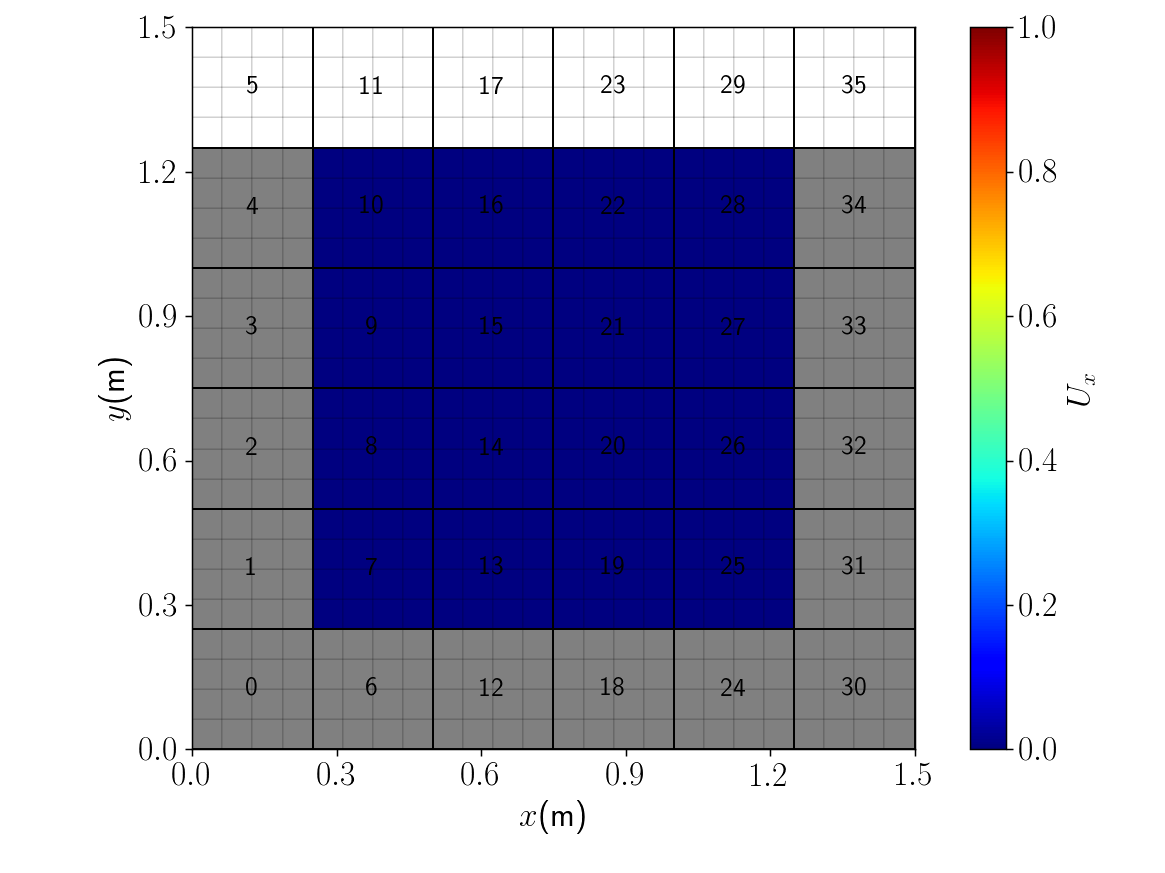

In [6]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [7]:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
plotSpaces(posSpace,'k',lspace,1)

In [ ]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Cavity_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [9]:
# Here we specify the output frequencies
dt_figure = 0.025*(L/2)**2*rhoF/mu
t_print = 0
#final time :
t_end = 0.7
t=0
it=0
im_count=0
ytab = np.linspace(-1,1,100)
timetab = np.linspace(0,5,60)

In [ ]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu,vecPer[0])
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        #FIGURE 1
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
            
        im_count = im_count+1
        t_print +=dt_figure
        